In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Image Captioning With gMLP

In [4]:
import einops

In [5]:
import string
import numpy as np
import pandas as pd
from numpy import array
from PIL import Image
import pickle
import json
import random
import collections

import matplotlib.pyplot as plt
import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
# from tensorflow.keras.layers import Add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [6]:
# annotation_file = '/content/drive/MyDrive/Senior_Project/mscoco/annotations/captions_train2014.json' #'/datasets/mscoco/annotations/captions_train2014.json' #'annotations/captions_train2014.json' 
# PATH = '/content/drive/MyDrive/Senior_Project/mscoco/train2014/' #'/datasets/mscoco/train2014/' # 'train2014/'

In [7]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

13510582272/13510573713 [==============================] - 246s 0us/step


In [8]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [9]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [10]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [11]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [12]:
assert len(train_captions) == len(img_name_vector)

In [13]:
# from pathlib import Path

# my_file = Path(img_name_vector[0])

In [14]:
# my_file.exists()

<start> A plate of food containing a sandwich and some fruit is resting on a table. <end>


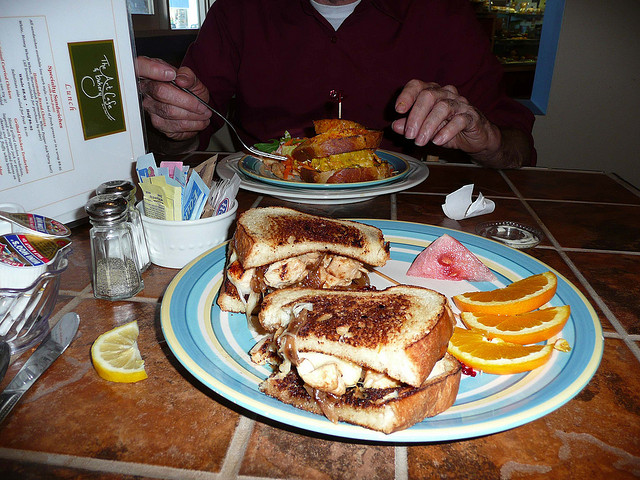

In [15]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess Image

In [16]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(299, 299)(img)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## InceptionV3 (2019) as an Encoder

In [17]:
# image_model = tf.keras.applications.InceptionV3(include_top=False,
#                                                 weights='imagenet')
# new_input = image_model.input
# hidden_layer = image_model.layers[-1].output

# image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. Install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [18]:
# from tqdm import tqdm

In [19]:
# # Get unique images
# encode_train = sorted(set(img_name_vector))

# # Feel free to change batch_size according to your system configuration
# image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
# image_dataset = image_dataset.map(
#   load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

# for img, path in tqdm(image_dataset):
#   batch_features = image_features_extract_model(img)
#   batch_features = tf.reshape(batch_features,
#                               (batch_features.shape[0], -1, batch_features.shape[3]))

#   for bf, p in zip(batch_features, path):
#     path_of_feature = p.numpy().decode("utf-8")
#     np.save(path_of_feature, bf.numpy())

## Vectorization

In [20]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50 
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [21]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [22]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

## Split the data into training and testing

In [23]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 60-20-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

val_slice_index = int(len(img_keys)*0.6)
test_slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys, img_name_test_keys = img_keys[:val_slice_index], img_keys[val_slice_index: test_slice_index], img_keys[test_slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

img_name_test = []
cap_test = []
for imgv in img_name_test_keys:
  capte_len = len(img_to_cap_vector[imgv])
  img_name_test.extend([imgv] * capte_len)
  cap_test.extend(img_to_cap_vector[imgv])

In [24]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val), len(img_name_test), len(cap_test)

(18009, 18009, 6005, 6005, 6005, 6005)

## Create a tf.data dataset for training

In [25]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
# embedding_dim = 256
# units = 512
# num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
# features_shape = 2048
# attention_features_shape = 64

# IMAGE_SIZE = (299, 299)

In [26]:
# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size
VOCAB_SIZE = 5000 # 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 100 # 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 30
AUTOTUNE = tf.data.AUTOTUNE

In [27]:
# # Load the numpy files
# def map_func(img_name, cap):
#     img_tensor = np.load(img_name.decode('utf-8')+'.npy')
#     return img_tensor, cap

In [28]:
# dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# # Use map to load the numpy files in parallel
# dataset = dataset.map(lambda item1, item2: tf.numpy_function(
#           map_func, [item1, item2], [tf.float32, tf.int64]),
#           num_parallel_calls=tf.data.AUTOTUNE)

# # # Shuffle and batch
# dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE) # Batch_size * (img_name_train, cap_train)
# dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), captions


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(len(images))
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(img_name_train, cap_train)

valid_dataset = make_dataset(img_name_val, cap_val)

test_dataset = make_dataset(img_name_test, cap_test)

In [30]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 50), dtype=tf.int64, name=None))>

## CNN Encoder

In [31]:
# class CNN_Encoder(tf.keras.Model):
#     # Since you have already extracted the features and dumped it
#     # This encoder passes those features through a Fully connected layer
#     def __init__(self, embedding_dim):
#         super(CNN_Encoder, self).__init__()
#         # shape after fc == (batch_size, 64, embedding_dim)
#         self.fc = tf.keras.layers.Dense(embedding_dim)

#     def call(self, x):
#         x = self.fc(x)
#         x = tf.nn.relu(x)
#         return x

## gMLP

### gMLP Architecture
From https://github.com/lucidrains/g-mlp-pytorch

In [32]:
import tensorflow as tf
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import Layer, LayerNormalization
from einops import rearrange, repeat
from random import randrange

In [33]:
def exists(val):
    return val is not None

In [34]:
def dropout_layers(layers, prob_survival):
    if prob_survival == 1:
        return layers

    num_layers = len(layers)
    to_drop = tf.random.uniform([num_layers], minval=0., maxval=1.) > prob_survival

    # make sure at least one layer makes it
    if all(to_drop):
        rand_index = randrange(num_layers)
        to_drop[rand_index] = False

    layers = [layer for (layer, drop) in zip(layers, to_drop) if not drop]
    return layers

In [35]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, d_out, d_attn, causal = False):
        super().__init__()
        
        self.d_attn = d_attn
        self.scale = d_attn ** -0.5

        self.proj_in = tf.keras.layers.Dense(3 * d_attn)
        self.proj_out = tf.keras.layers.Dense(d_out)
        self.causal = causal

    def call(self, x):
        qkv = self.proj_in(x)
        q, k, v = tf.split(qkv, num_or_size_splits=3, axis=-1)
        w = tf.einsum('bid,bjd->bij', q, k) * self.scale

        if self.causal:
            mask = tf.ones(w.shape[-2:])

            # band_part and set_diag replace triu(1) in lucidrains' implementation
            mask = tf.linalg.band_part(mask, 0, -1)
            mask_diag = tf.linalg.diag_part(mask)
            mask = tf.linalg.set_diag(mask, tf.zeros_like(mask_diag))
            mask = tf.cast(mask, dtype=tf.bool)

            w = tf.where(mask[None, ...], tf.ones_like(w) * -q.dtype.max, w)

        a = tf.nn.softmax(w * tf.math.rsqrt(float(self.d_attn)), axis=-1)
        out = tf.einsum('bij,bjd->bid', a, v)
        return self.proj_out(out)

In [36]:
class SpatialGatingUnit(Layer):
    def __init__(self, 
                dim_seq, 
                causal = False, 
                activation = tf.identity, 
                heads = 1,
                init_eps = 1e-3,
                circulant_matrix = False,
                kernel_regularizer=None,
                bias_regularizer=None):
        
        super().__init__()
        self.dim_seq = dim_seq
        self.causal = causal
        self.activation = activation
        self.init_eps = init_eps / dim_seq

        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.heads = heads

        # parameters
        if circulant_matrix:
            self.circulant_pos_x = tf.ones((heads, dim_seq))
            self.circulant_pos_y = tf.ones((heads, dim_seq))

        self.circulant_matrix = circulant_matrix
        shape = (heads, dim_seq,) if circulant_matrix else (heads, dim_seq, dim_seq)
        self.shape = shape

        self.heads = heads

    def build(self, _):

        self.dense_bias = self.add_weight(
            name="sgu_dense_bias", 
            regularizer=self.bias_regularizer,
            shape=(self.heads, self.dim_seq), # 1 is the number of heads
            initializer=tf.ones
        )
        
        self.dense_weight = self.add_weight(
            name="sgu_dense_kernel", 
            regularizer=self.kernel_regularizer,
            shape=self.shape, 
            initializer=RandomUniform(minval=-self.init_eps, maxval=self.init_eps)
        )

        self.norm = LayerNormalization()

    def call(self, x, tiny_attn=None):
        device, n, h = x.device, x.shape[1], self.heads

        res, gate = tf.split(x, 2, axis=-1)
        gate = self.norm(gate)

        weight, bias = self.dense_weight, self.dense_bias
        
        if self.circulant_matrix:
            # build the circulant matrix
            dim_seq = weight.shape[-1]
            paddings = tf.constant([[0, 0], [0, dim_seq]])
            weight = tf.pad(weight, paddings, constant_values=0)
            weight = repeat(weight, '... n -> ... (r n)', r = dim_seq)
            weight = tf.reshape(weight[:, :-dim_seq], [h, dim_seq, 2 * dim_seq - 1])
            weight = weight[:, :, (dim_seq - 1):]

            # give circulant matrix absolute position awareness

            pos_x, pos_y = self.circulant_pos_x, self.circulant_pos_y
            weight = weight * rearrange(pos_x, 'h i -> h i ()') * rearrange(pos_y, 'h j -> h () j')
        
        if self.causal:
            weight, bias = weight[:, :n, :n], bias[:,:n]
            mask = tf.ones(weight.shape[-2:])

            # band_part and set_diag replace triu(1) in lucidrains' implementation
            mask = tf.linalg.band_part(mask, 0, -1)
            mask_diag = tf.linalg.diag_part(mask)
            mask = tf.linalg.set_diag(mask, tf.zeros_like(mask_diag))
            mask = tf.cast(mask, dtype=tf.bool)

            mask = rearrange(mask, 'i j -> () i j')
            weight = tf.where(mask, tf.zeros_like(weight), weight)


        gate = rearrange(gate, 'b n (h d) -> b h n d', h = h)


        gate = tf.einsum('bhnd, hmn->bhmd', gate, weight)
        gate = gate + rearrange(bias, 'h n -> () h n ()')

        gate = rearrange(gate, 'b h n d -> b n (h d)')
        
        if exists(tiny_attn):
            gate = gate + tiny_attn

        return self.activation(gate) * res # dimension at axis = -1 gets halved

In [37]:
# ***** gMLP-block works as a self-attention *****
class gMLP_Block(tf.keras.Model):
    def __init__(self, d_ffn, d_model, seq_len, heads=1, circulant_matrix = False, causal=False, attn_dim=None, act=tf.identity):
        super().__init__()
        
        self.norm_layer = tf.keras.layers.LayerNormalization(axis=-1)
        
        self.proj_in = tf.keras.layers.Dense(d_ffn, activation='gelu')

        # attention
        self.tiny_attn = Attention(d_ffn // 2, attn_dim, causal=causal) if attn_dim else None

        self.sgu = SpatialGatingUnit(seq_len, causal=causal, activation=act, heads=heads, circulant_matrix = circulant_matrix)
        self.proj_out = tf.keras.layers.Dense(d_model)
        
    def call(self, x):
        # word_embedding
        shortcut = x

        x = self.norm_layer(x)

        attn = self.tiny_attn(x) if self.tiny_attn else None

        x = self.proj_in(x)
        x = self.sgu(x, tiny_attn=attn)
        x = self.proj_out(x)
        
        x = x + shortcut
        
        return x

In [38]:
class gMLPDecoderLayer(tf.keras.layers.Layer):
    """
      Combine text embedding with image features
    """
    def __init__(self, d_ffn, d_model, seq_len, heads=1, circulant_matrix = False, causal=False, attn_dim=None, act=tf.identity):
        super().__init__()
        
        self.gmlp_block = gMLP_Block(d_ffn=d_ffn, d_model=d_model, heads=heads, seq_len=seq_len, attn_dim=attn_dim, causal=causal, act=act, circulant_matrix=circulant_matrix)
        # for image
        self.gmlp_block_2 = gMLP_Block(d_ffn=d_ffn, d_model=d_model, heads=heads, seq_len=seq_len, attn_dim=attn_dim, causal=causal, act=act, circulant_matrix=circulant_matrix)

    def call(self, x, enc_output):
        seq_len = tf.shape(x)[1]
        
        # look ahead mask
        out = self.gmlp_block(x)

        enc_output = tf.expand_dims(enc_output, axis=1)
        out = enc_output + out


        # --------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        out = self.gmlp_block_2(out)
        # --------------------------------------------------------------------------------------------------------------------------------------------------------------------------

        

        return out

### gMLP NLP

In [39]:
# top k filtering

def top_k(logits, thres = 0.9):
    k = int((1 - thres) * logits.shape[-1])
    val, ind = tf.math.top_k(logits, k)
    probs = tf.fill(logits.shape, float('-inf'))
    probs.scatter_(1, ind, val)
    return probs

In [40]:
def eval_decorator(fn):
    def inner(model, *args, **kwargs):
        out = fn(model, *args, **kwargs)
        return out
    return inner

In [41]:
# import tensorflow_probability as tfp

In [42]:
# class AutogressiveWrapper(tf.keras.Model):
#     def __init__(self, net, ignore_index = -100, pad_value=0):
#         super().__init__()
#         self.pad_value = pad_value
#         self.ignore_index = ignore_index

#         self.net = net
#         self.max_seq_len = net.seq_len

#     \@eval_decorator
#     def generate(self, start_tokens, seq_len, eos_token = None, temperature = 1., filter_logits_fn = top_k, filter_thres = 0.9, **kwargs):
#         num_dims = len(start_tokens.shape)

#         if num_dims == 1:
#             start_tokens = start_tokens[None, :]

#         b, t = start_tokens.shape

#         out = start_tokens

#         for _ in range(seq_len):
#             x = out[:, -self.max_seq_len:]

#             # TODO: pass input features
#             logits = self.net(x, **kwargs)[:, -1, :]

#             filtered_logits = top_k(logits, thres = filter_thres)
#             probs = tf.nn.softmax(filtered_logits / temperature, dim=-1)

#             dist = tfp.distributions.Multinomial(1, probs=probs)
#             sample = tf.where(tf.equal(dist.sample(1)[0], 1))[0]

#             out = tf.concat([out, sample], axis=-1)

#             if eos_token is not None and (sample == eos_token).all():
#                 break

#         out = out[:, t:]

#         if num_dims == 1:
#             out = out.squeeze(0)
#         return out

#     def call(self, x, **kwargs):
#         xi, xo = x[:, :-1], x[:, 1:]
#         out = self.net(xi, **kwargs)
#         loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

#         loss = loss_function(xo, tf.transpose(out, perm=[1, 2]))
#         return loss

In [43]:
class gMLPNLP(tf.keras.Model):
    def __init__(self, *, num_tokens=None, embedding_dim, depth, seq_len, heads=1, ff_mult=4, attn_dim=None, prob_survival = 1., causal=False, circulant_matrix = False, act=tf.identity):
        super().__init__()
        
        assert (embedding_dim % heads) == 0, 'dimension must be divisible by number of heads'

        dim_ff = embedding_dim * ff_mult
        self.seq_len = seq_len
        self.prob_survival = prob_survival
        self.embedding_dim = embedding_dim
        
        self.to_embed = tf.keras.layers.Embedding(num_tokens, embedding_dim) if num_tokens else tf.identity

        self.gmlp_layers = [gMLPDecoderLayer(d_ffn=dim_ff, d_model=embedding_dim, heads=heads, seq_len=seq_len, attn_dim=attn_dim, causal=causal, act=act, circulant_matrix=circulant_matrix) for i in range(depth)]

        self.to_logits = tf.keras.Sequential([
            tf.keras.layers.LayerNormalization(),
            tf.keras.layers.Dense(num_tokens)
        ]) if num_tokens else tf.identity
        
    def call(self, x, img_features, is_training=True):        
        x = self.to_embed(x) # batch_size, seq_len, embedding_dim
        x *= tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        gmlp_layers = self.gmlp_layers if not is_training else dropout_layers(self.gmlp_layers, self.prob_survival)
        
        for layer in gmlp_layers:
            x = layer(x, img_features)

        out = x
        return self.to_logits(out) # (batch_size, tar_seq_len, target_vocab_size)

## gMLPVision

In [44]:
def pair(val):
    return (val, val) if not isinstance(val, tuple) else val

In [45]:
class RearrangeLayer(tf.keras.layers.Layer):
    def __init__(self, patch_height, patch_width):
        super().__init__()
        self.patch_height = patch_height
        self.patch_width = patch_width

    def call(self, x):
        return rearrange(x, 'b (h p1) (w p2) c -> b (h w) (c p1 p2)', p1 = self.patch_height, p2 = self.patch_width)

In [46]:
class ReduceLayer(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def call(self, x):
        return tf.reduce_mean(x, 1)

In [47]:
class gMLPVision(tf.keras.Model):
    def __init__(
        self,
        *,
        image_size,
        patch_size,
        dim,
        depth,
        heads = 1,
        ff_mult=4, 
        channels = 3,
        attn_dim = None,
        prob_survival = 1.
    ):
        super().__init__()
        assert (dim % heads) == 0, 'dimension must be divisible by number of heads'

        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)
        assert (image_height % patch_height) == 0 and (image_width % patch_width) == 0, 'image height and width must be divisible by patch size'
        num_patches = (image_height // patch_height) * (image_width // patch_width)

        dim_ff = dim * ff_mult

        self.to_patch_embed = tf.keras.Sequential(
            [
             RearrangeLayer(patch_height, patch_width), 
             tf.keras.layers.Dense(dim)]
        )

        self.prob_survival = prob_survival

        self.gmlp_layers = [gMLP_Block(d_model=dim, heads=heads, d_ffn=dim_ff, seq_len=num_patches, attn_dim=attn_dim) for _ in range(depth)]

        self.to_logits = tf.keras.Sequential(
          [tf.keras.layers.LayerNormalization(),
           ReduceLayer()]
        )
    def call(self, x, is_training=True):
        x = self.to_patch_embed(x)

        gmlp_layers = self.gmlp_layers if not is_training else dropout_layers(self.gmlp_layers, self.prob_survival)
        x = tf.keras.Sequential(gmlp_layers)(x)
        return self.to_logits(x)

### Simple Test

In [48]:
# model = gMLPVision(
#     image_size = 256,
#     patch_size = 16,
#     dim = 512,
#     depth = 6
# )

# img = tf.random.normal((1, 256, 256, 3)) # batch size, image_width, image_height, channel
# logits = model(img, is_training=True) # (1, 1000)

In [49]:
# model = gMLPNLP(
#     num_tokens = 20000,
#     embedding_dim = 512,
#     depth = 6,
#     seq_len = 256,
#     circulant_matrix = True,      # use circulant weight matrix for linear increase in parameters in respect to sequence length
#     act = tf.math.tanh               # activation for spatial gate (defaults to identity)
# )

# x = tf.random.uniform((1, 256), minval=0, maxval=20000)
# logits = model(x) # (1, 256, 20000)

In [50]:
# logits.shape

## Model Training

### Model Hyperparameters

In [51]:
num_layer = 1
d_model = 512
num_heads = 8
target_vocab_size = VOCAB_SIZE + 1 # + unknown token

In [52]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
   def __init__(self, d_model, warmup_steps=4000):
      super(CustomSchedule, self).__init__()
      self.d_model = d_model
      self.d_model = tf.cast(self.d_model, tf.float32)
      self.warmup_steps = warmup_steps

   def __call__(self, step):
      arg1 = tf.math.rsqrt(step)
      arg2 = step * (self.warmup_steps ** -1.5)
      return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [53]:
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)

In [54]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

# cnn_model = get_cnn_model()

encoder = gMLPVision(
    image_size = IMAGE_SIZE,
    patch_size = 13,
    dim = 512,
    depth = num_layer,
    attn_dim=64
    )
decoder = gMLPNLP(num_tokens=target_vocab_size, depth=num_layer, embedding_dim=d_model, heads=num_heads, seq_len=SEQ_LENGTH, causal=True, circulant_matrix=True, attn_dim=64) # attn_dim=64

### Checkpoint

In [55]:
checkpoint_path = '/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/gMLP_mscoco_uncommented'

ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

In [56]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    print(ckpt_manager.latest_checkpoint)
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
    # restoring the latest checkpoint in checkpoint_path
    ckpt.restore(ckpt_manager.latest_checkpoint)

/content/drive/MyDrive/My Senior Project Spring 2022/checkpoint/gMLP_mscoco_uncommented/ckpt-20


In [57]:
print(start_epoch)

20


### Model Training

In [58]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [59]:
def train_step(img_tensor, tar, is_training):
    # 1. Get image embeddings
    # img_tensor = cnn_model(img_tensor)

    # 2. Pass each of the five captions one by one to the decoder
    # along with the encoder outputs and compute the loss as well as accuracy
    # for each caption.
    # num_captions_per_image = 5
    all_captions_loss = 0
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    if is_training:
        with tf.GradientTape() as tape:
            features = encoder(img_tensor, is_training)
            predictions = decoder(tar_inp, features, is_training)

            loss = loss_function(tar_real, predictions)
            all_captions_loss += loss

            trainable_variables = encoder.trainable_variables + decoder.trainable_variables
            gradients = tape.gradient(loss, trainable_variables)   
            optimizer.apply_gradients(zip(gradients, trainable_variables))
    
            train_loss(loss)
            train_accuracy(tar_real, predictions)
    else:
        features = encoder(img_tensor, is_training)
        predictions = decoder(tar_inp, features, is_training)
        loss = loss_function(tar_real, predictions)

        val_loss(loss)
        val_accuracy(tar_real, predictions)

In [60]:
train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

for epoch in range(start_epoch, 21):
   start = time.time()
   train_loss.reset_states()
   train_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(train_dataset):
      train_step(img_tensor, tar, True)
      if batch % 50 == 0:
         print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
         epoch + 1, batch, train_loss.result(), train_accuracy.result()))
   train_losses.append(train_loss.result() / 5)
   train_accuracies.append(train_accuracy.result() / 5)

   # validation
   val_loss.reset_states()
   val_accuracy.reset_states()
   for (batch, (img_tensor, tar)) in enumerate(valid_dataset):
     train_step(img_tensor, tar, False)
     if batch % 50 == 0:
         print ('Epoch {} Batch {} Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(
         epoch + 1, batch, val_loss.result(), val_accuracy.result()))

   val_losses.append(val_loss.result() / 5)
   val_accuracies.append(val_accuracy.result() / 5)
   if epoch % 10 == 0:
      ckpt_manager.save(checkpoint_number=epoch)     

   print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                               train_loss.result(),
                                               train_accuracy.result()))
   
   print ('Epoch {} Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                               val_loss.result(),
                                               val_accuracy.result()))
   
   print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 21 Batch 0 Loss 6.2297 Accuracy 0.0504
Epoch 21 Batch 50 Loss 4.8932 Accuracy 0.0655
Epoch 21 Batch 100 Loss 4.5712 Accuracy 0.0716
Epoch 21 Batch 150 Loss 4.3629 Accuracy 0.0750
Epoch 21 Batch 200 Loss 4.2051 Accuracy 0.0775
Epoch 21 Batch 250 Loss 4.0834 Accuracy 0.0795
Epoch 21 Batch 0 Validation Loss 3.6658 Validation Accuracy 0.0886
Epoch 21 Batch 50 Validation Loss 3.5129 Validation Accuracy 0.0884
Epoch 21 Loss 4.0207 Accuracy 0.0805
Epoch 21 Validation Loss 3.5291 Validation Accuracy 0.0883
Time taken for 1 epoch: 97.23449063301086 secs



## Evaluate

In [61]:
from nltk.translate.bleu_score import sentence_bleu

In [62]:
def evaluate(image):
   temp_input = tf.expand_dims(decode_and_resize(image), 0)
   img_tensor_val = temp_input
  #  img_tensor_val = cnn_model(temp_input)
  #  img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
   start_token = word_to_index(tf.constant('<start>'))
   end_token = word_to_index(tf.constant('<end>'))
   decoder_input = [start_token]
   output = tf.expand_dims(decoder_input, 0) #tokens
   result = [] #word list

   for i in range(100):
      features = encoder(img_tensor_val)
      predictions = decoder(output, features)

      predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
      predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int64)
      if predicted_id == end_token:
         return result,tf.squeeze(output, axis=0)
      result.append(tf.compat.as_text(index_to_word(int(predicted_id.numpy())).numpy()))
      output = tf.concat([output, predicted_id], axis=-1)

   return result,tf.squeeze(output, axis=0)

In [63]:
def test_single_img(id):
  image = img_name_test[id]

  caption = cap_test[id]

  bleu_scores = []
  # for caption in captions:
  real_caption = ' '.join([tf.compat.as_text(index_to_word(i).numpy()) for i in caption if i not in [0]])
  caption, result = evaluate(image)

  first = real_caption.split(' ', 1)[1]
  real_caption = first.rsplit(' ', 1)[0]

  for i in caption:
    if i=="<unk>":
        caption.remove(i)

  for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

  result_join = ' '.join(caption)
  result_final = result_join.rsplit(' ', 1)[0]
  real_appn = []
  real_appn.append(real_caption.split())
  reference = real_appn
  candidate = caption

  # score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
  # print(f"BLEU-1 score: {score*100}")
  # score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
  # print(f"BLEU-2 score: {score*100}")
  # score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
  # print(f"BLEU-3 score: {score*100}")
  score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
  bleu_scores.append(score)
  print(f"BLEU-4 score: {score*100}")

  print ('Real Caption:', real_caption)
  print ('Predicted Caption:', ' '.join(caption))
  temp_image = np.array(Image.open(image))
  plt.imshow(temp_image)

  return np.mean(bleu_scores)

BLEU-4 score: 48.7191740069029
Real Caption: a woman in a bra like top and shorts holding a tennis racket.
Predicted Caption: a baseball player swings a bat on a field


0.487191740069029

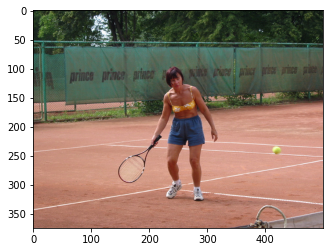

In [79]:
test_single_img(24)

BLEU-4 score: 0
Real Caption: several baskets of apples, oranges and other various fruits.
Predicted Caption: a man is standing in a field with a large [UNK]
BLEU-4 score: 65.29942057256105
Real Caption: a display case filled with lots of fruits and vegetables.
Predicted Caption: a man is standing in a field with a large [UNK]
BLEU-4 score: 65.29942057256105
Real Caption: fresh [UNK] laid out at a market stall
Predicted Caption: a man is standing in a field with a large [UNK]
BLEU-4 score: 65.29942057256105
Real Caption: a bunch pf red and green apples in plastic containers
Predicted Caption: a man is standing in a field with a large [UNK]
BLEU-4 score: 65.29942057256105
Real Caption: a market with various types of displayed fruits.
Predicted Caption: a man is standing in a field with a large [UNK]
BLEU-4 score: 42.45672557693626
Real Caption: a person on a beach flying a red kite.
Predicted Caption: a man on a surfboard in the ocean.
BLEU-4 score: 37.46792881553041
Real Caption: a per

KeyboardInterrupt: ignored

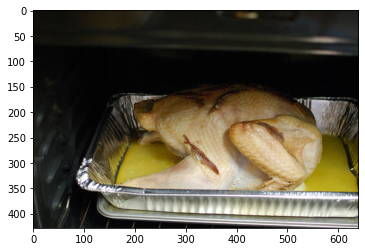

In [ ]:
bleu_scores = []
for i in range(len(img_name_test)):
  bleu_score = test_single_img(i)
  bleu_scores.append(bleu_score)

np.mean(bleu_scores)